In [1]:
import pandas as pd
import csv
import math

In [2]:
# load the datasets
housing_df = pd.read_csv('./data/raw_austin_housing_data_w_crime_density.csv', low_memory=False)

In [3]:
# function for calculating Haversine distance
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

In [4]:
# constants
lat_key = 'latitude'
lon_key = 'longitude'
seg_lat = 50
seg_lon = 50
min_lat = 30.0727239
max_lat = 30.5193782
min_lon = -98.0158212
max_lon = -97.4053586
del_lat = (max_lat - min_lat) / seg_lat
del_lon = (max_lon - min_lon) / seg_lon

desired_range_km = 3
lat_step_km = distance((min_lat, min_lon), (min_lat + del_lat, min_lon))
lon_step_km = distance((min_lat, min_lon), (min_lat, min_lon + del_lon))
avg_step_km = (lat_step_km + lon_step_km) / 2
num_steps = math.ceil(desired_range_km / avg_step_km)
search_range = range(-num_steps, num_steps + 1)

In [5]:
# create a function to add column to housing data
def add_poi_to_housing(category):
    print('\n\nadding ' + category + ' index to housing data')

    # load the category index data
    index_data = list(csv.reader(open('./data/poi_index_' + category + '.csv')))

    # prep the column in the housing dataframe for this category index
    housing_df[category + '_index'] = 0

    # iterate through all housing data and compute crime
    print('Iterating through ' + str(len(housing_df)) + ' houses:')
    for hidx,house in housing_df.iterrows():
        print('\rProcessing house no: {}'.format(hidx), end="\r")
        house_lat = house[lat_key]
        house_lon = house[lon_key]

        # skip houses that are not in our bounds
        if (house_lat < min_lat or 
            house_lat > max_lat or 
            house_lon < min_lon or 
            house_lon > max_lon):
            continue

        # find the grid index the house is in
        d_from_min_lat = house_lat - min_lat
        d_from_min_lon = house_lon - min_lon
        idx_lat = math.floor(d_from_min_lat / del_lat)
        idx_lon = math.floor(d_from_min_lon / del_lon)

        # keep track of the index score
        category_score = 0

        # iterate through all neighboring grid squares to find crime
        for radius_lat in search_range:
            for radius_lon in search_range:
                search_lat_idx = idx_lat + radius_lat
                search_lon_idx = idx_lon + radius_lon

                # check if we're on the edge
                if (search_lat_idx < 0 or 
                    search_lat_idx >= seg_lat or 
                    search_lon_idx < 0 or 
                    search_lon_idx >= seg_lon):
                    continue

                # add to running total
                category_score += int(index_data[search_lat_idx][search_lon_idx])

        # persist the calculated value
        housing_df.at[housing_df.index[hidx], category + '_index'] = category_score

In [6]:
add_poi_to_housing('park')
add_poi_to_housing('schools')
add_poi_to_housing('event')
add_poi_to_housing('fastfood')



adding park index to housing data
Iterating through 61793 houses:
Processing house no: 61792

adding schools index to housing data
Iterating through 61793 houses:
Processing house no: 61792

adding event index to housing data
Iterating through 61793 houses:
Processing house no: 61792

adding fastfood index to housing data
Iterating through 61793 houses:
Processing house no: 61792

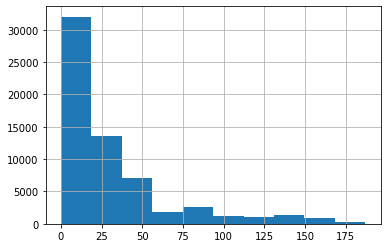

In [7]:
housing_df['park_index'].hist()

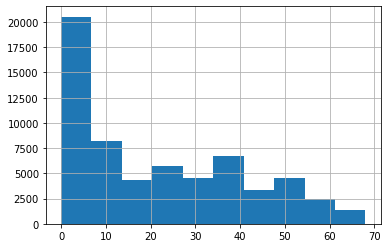

In [8]:
housing_df['schools_index'].hist()

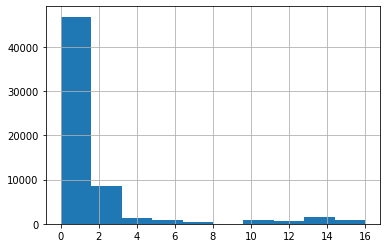

In [9]:
housing_df['event_index'].hist()

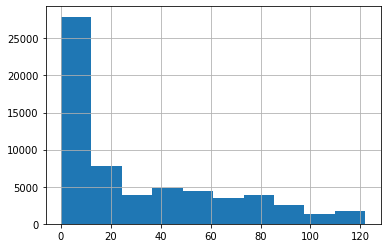

In [10]:
housing_df['fastfood_index'].hist()

In [11]:
housing_df.to_csv('data/raw_austin_housing_data_w_crime_density_poi.csv')